# Import all Necessary Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers.experimental import SyncBatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.utils import to_categorical

# Data preparation

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

X = x_train
y = y_train

In [3]:
X = X / 255.0

## Reshape

In [4]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
X = X.reshape(-1,28,28,1)

## Label encoding

**One-Hot Encoding**

In [5]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y = to_categorical(y)

print(f"Label size {y.shape}")

Label size (60000, 10)


## Split training and valdiation set

In [6]:
# Split the train and the validation set for the fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

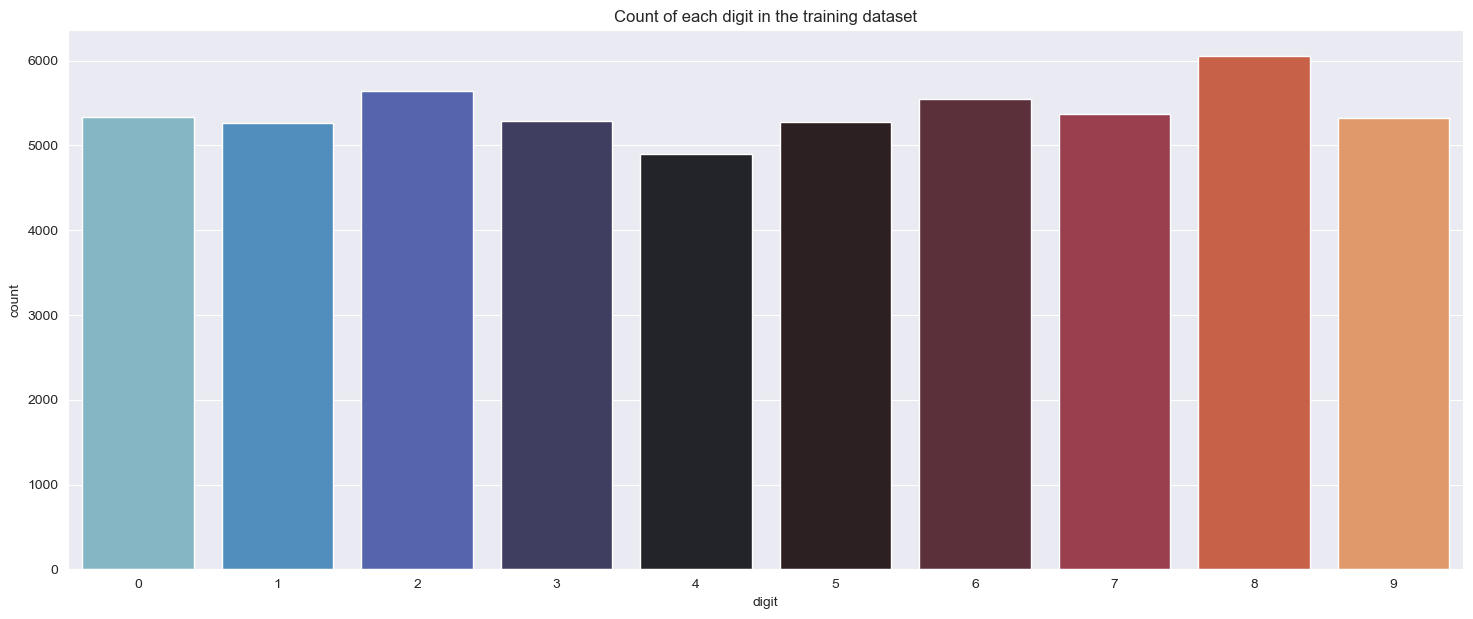

In [30]:
y_pd = pd.DataFrame(y_train)
y_pd_plot = pd.DataFrame(y_pd.value_counts(),columns=["count"]).sort_index()
y_pd_plot['digit'] = [i for i in range(0,10)]
# print(y_pd_plot)
fig, ax = plt.subplots(figsize = (18,7))
ax.set_title("Count of each digit in the training dataset")
sns.barplot(data=y_pd_plot, y='count', x='digit', palette="icefire")
plt.show()

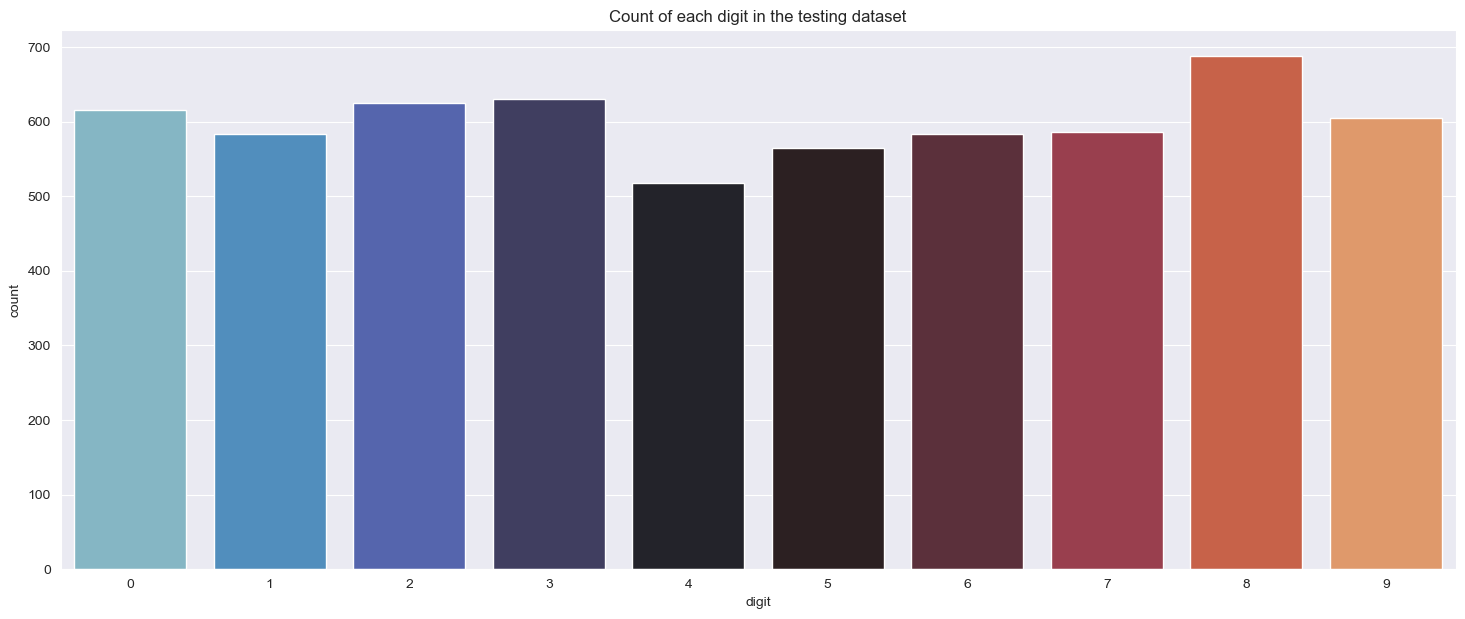

In [31]:
y_pd = pd.DataFrame(y_test)
y_pd_plot = pd.DataFrame(y_pd.value_counts(),columns=["count"]).sort_index()
y_pd_plot['digit'] = [i for i in range(0,10)]
# print(y_pd_plot)
fig, ax = plt.subplots(figsize = (18,7))
ax.set_title("Count of each digit in the testing dataset")
sns.barplot(data=y_pd_plot, y='count', x='digit', palette="icefire")
plt.show()

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((54000, 28, 28, 1), (6000, 28, 28, 1), (54000, 10), (6000, 10))

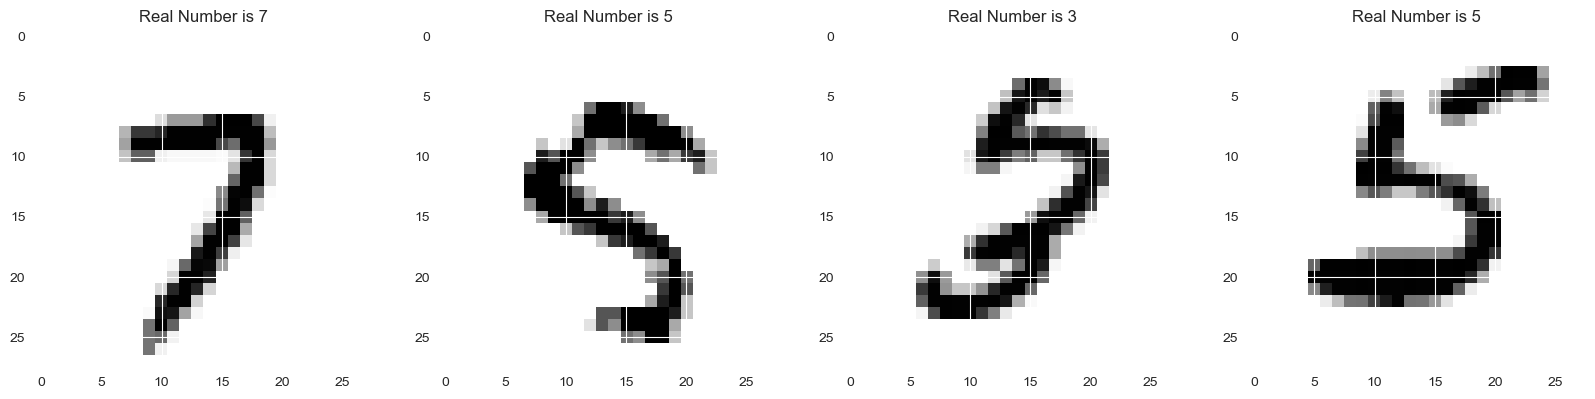

In [8]:
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

In [9]:
mean = np.mean(X_train)
std = np.std(X_train)

def standardize(x):
    return (x-mean)/std

# Model Definition

In [10]:
model=Sequential()

model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(SyncBatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(SyncBatchNormalization())

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(SyncBatchNormalization())
    
model.add(Flatten())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(10,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 sync_batch_normalization (  (None, 12, 12, 64)        256       
 SyncBatchNormalization)                                         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         1

## Data augmentation

In [12]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=128)
test_gen = datagen.flow(X_test, y_test, batch_size=128)

In [15]:
epochs = 5
batch_size = 128
train_steps = X_train.shape[0] // batch_size
valid_steps = X_test.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="accuracy", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [17]:
# Fit the model
history = model.fit(train_gen,
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps, 
                              callbacks=[es, rp])

Epoch 1/5
421/421 [==============================] - 153s 361ms/step - loss: 0.0401 - accuracy: 0.9878 - val_loss: 0.0559 - val_accuracy: 0.9849 - lr: 0.0010
Epoch 2/5
421/421 [==============================] - 154s 365ms/step - loss: 0.0364 - accuracy: 0.9889 - val_loss: 0.0300 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 3/5
421/421 [==============================] - 153s 364ms/step - loss: 0.0330 - accuracy: 0.9901 - val_loss: 0.0387 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 4/5
421/421 [==============================] - 156s 370ms/step - loss: 0.0323 - accuracy: 0.9906 - val_loss: 0.0259 - val_accuracy: 0.9929 - lr: 0.0010
Epoch 5/5
421/421 [==============================] - 157s 372ms/step - loss: 0.0284 - accuracy: 0.9916 - val_loss: 0.0474 - val_accuracy: 0.9862 - lr: 0.0010


# Evaluate the model
## Training and validation curves

In [24]:
print(history.history)

{'loss': [0.04006725177168846, 0.03637370839715004, 0.03298257663846016, 0.03229100629687309, 0.028423182666301727], 'accuracy': [0.9877672791481018, 0.9888810515403748, 0.9901247620582581, 0.9905887842178345, 0.9916097521781921], 'val_loss': [0.055870264768600464, 0.030049894005060196, 0.03868718817830086, 0.025870732963085175, 0.047417376190423965], 'val_accuracy': [0.98488450050354, 0.99167799949646, 0.98879075050354, 0.9928668737411499, 0.9862431883811951], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001]}


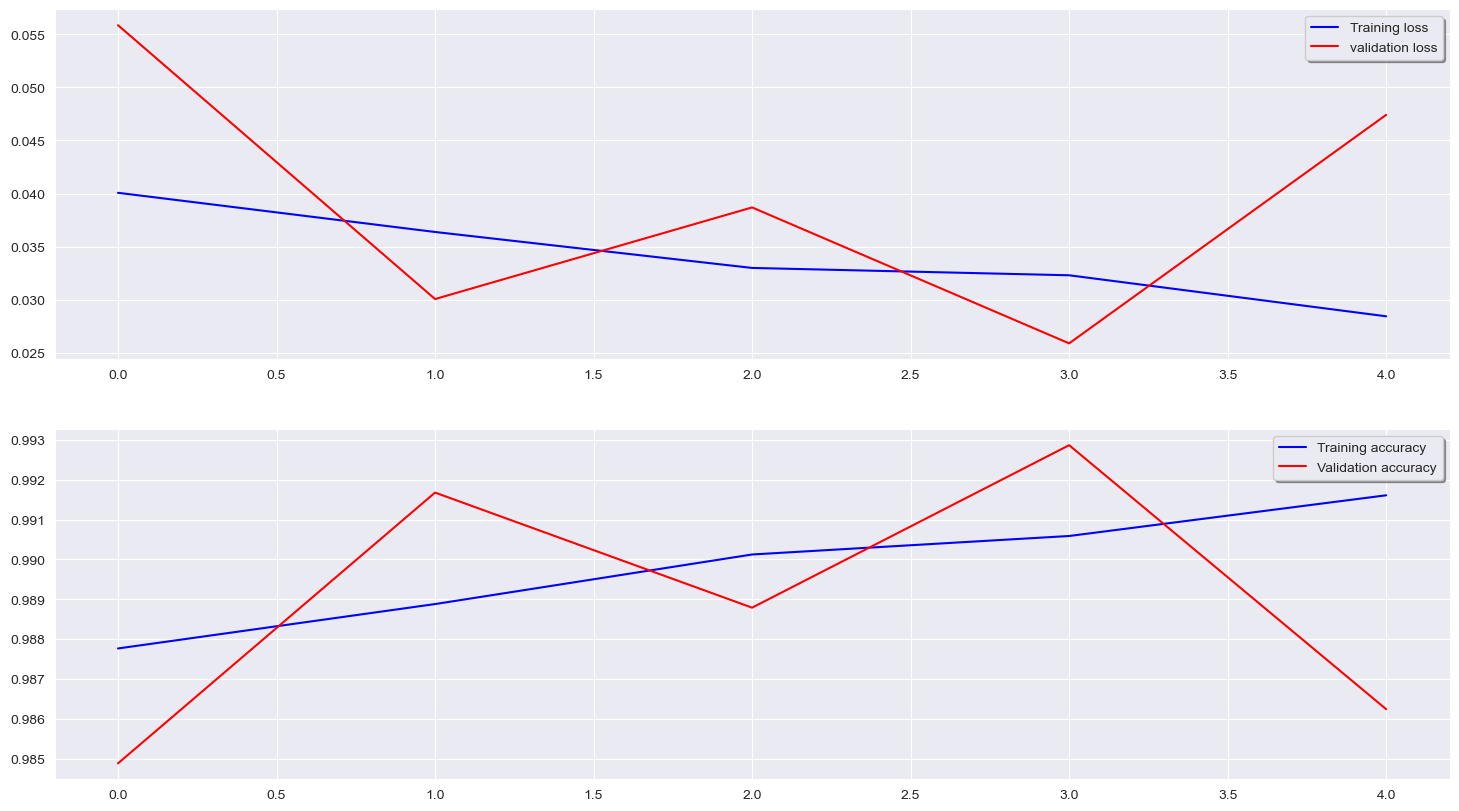

In [25]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Confusion matrix

188/188 [==============================] - 5s 29ms/step


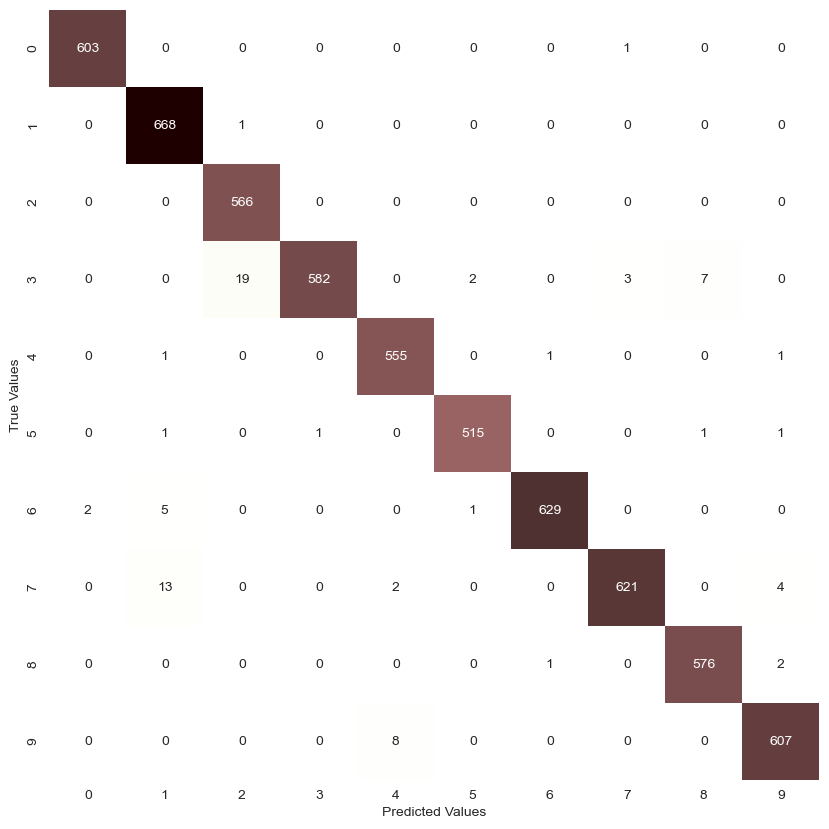

In [33]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.pink_r, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show();

## Prediction validation results

188/188 [==============================] - 6s 31ms/step


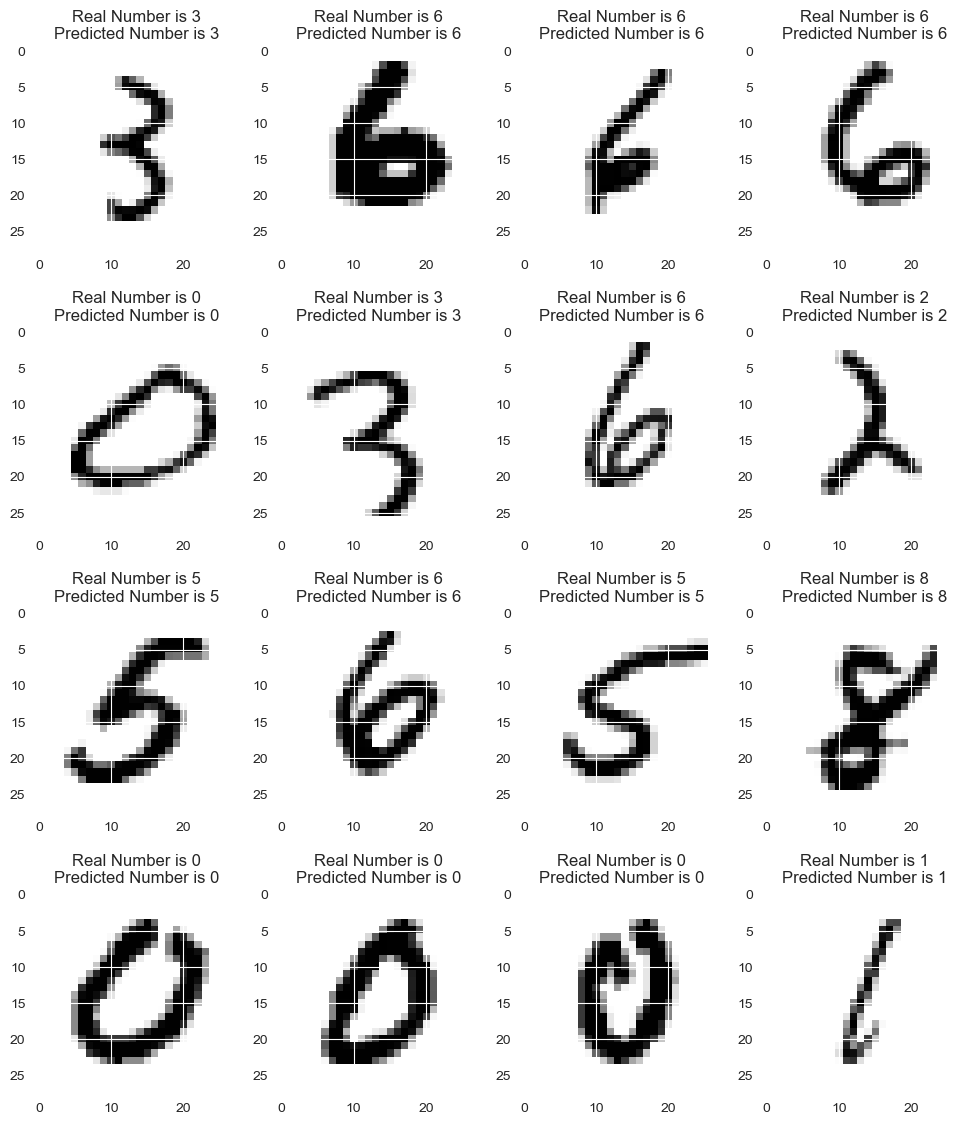

In [32]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredicted Number is {y_pred[i].argmax()}");

## ROC Curve and AUC

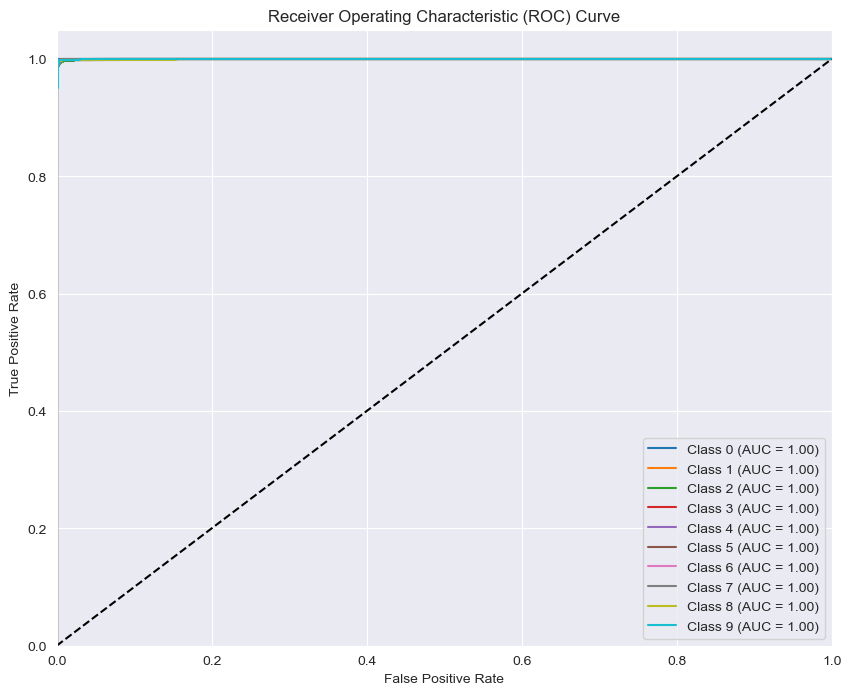

In [28]:
from sklearn.metrics import roc_curve, auc

# Compute class-wise ROC curve and AUC
n_classes = 10  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()